## Purpose of this Project

### We would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

#### This notebook will explore:

1. Distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. What is the average time to cancel on average? Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Distribution of average ETA by hours. How can this plot be explained?

### Next Steps

+ Read in datasets and begin exploring

In [1]:
# reading in the libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# reading in offers csv
offers = pd.read_csv('data/data_offers.csv')

# reading in orders.csv
orders = pd.read_csv('data/data_orders.csv')

### First Steps

+ Load in offers and orders dataset
+ Look at the first five rows 

In [2]:
# looking at the first five rows of the offers dataset
offers.head(5)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [3]:
# understanding the data landscape of the offers dataset
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [4]:
# looking at the first five columns of the orders dataset
orders.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
# understanding the data landscape of the orders dataset
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


### Next Steps

+ Manipulation of data will be more efficient if the tables are merged
+ Merge the tables on the order number
+ Merging tables is the python version of joining tables in SQL
+ Defining the how to merge the table (outer, left, right, inner) and on a specific row or rows is the purpose

In [6]:
# merging the tables and rename column order_datetime to order_date
df = pd.merge(orders, offers, how = 'inner', on = 'order_gk').rename({"order_datetime" : "order_time"}, axis = 1)
df

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275
...,...,...,...,...,...,...,...,...,...
31263,12:44:11,-0.975372,51.457846,NaN,3000597886155,4,0,43.0,300051590196
31264,12:42:52,-0.975372,51.457846,NaN,3000597886140,4,0,44.0,300051590176
31265,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,300051648809
31266,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,300051648910


In [7]:
# taking a random sample from the dataset and looking at ten examples
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628


### Observation

+ After merging and looking at the data, two columns stuck out and believe we can feature engineer them to be more readable
+ They are:
+ is_driver_assigned_key - whether a driver has been assigned. Instead of 1 and 0 for Yes and No, Yes and No would help read the data easier
+ order_status_key - status, an enumeration consisting of the following mapping:
- 4 - cancelled by client,
- 9 - cancelled by system, i.e., a reject

+ Instead of 4 and 9, we can feature engineer it to read Client Cancellation instead of 4, and System Cancellation instead if 9

### Next Steps

+ This can be performed using the numpy where function
+ It essentially works like an =IF() statement in google sheets where if the condition is true, you can give it a specific label or else name the label something different
+ Ie. If order_status_key equals 4, label it Client Cancellation, or else name it System Cancellation
+ In SQL, this is similar to the CASE WHEN function 
+ Ie. CASE WHEN order_status_key = 4 THEN 'Client Cancellation' ELSE 'System Cancellation' END 

In [8]:
# using the numpy where function on the is_driver_assigned_key, renaming the column and replacing 1, 0 with Yes or No to make improve data readibility
df['is_driver_assigned'] = np.where(df['is_driver_assigned_key'] == 1, "Yes", "No")

# using the numpy where function on the order_status_key, renaming the column and replacing 4, 9 with Client Cancellation or System Cancellation to make improve data readibility
df['order_status'] = np.where(df['order_status_key'] == 4, "Client Cancellation", "System Cancellation")

# taking a random sample from the dataset and looking at ten examples
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946,Yes,Client Cancellation
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519,No,Client Cancellation
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740,No,Client Cancellation
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394,No,Client Cancellation
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163,No,Client Cancellation
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313,No,System Cancellation
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742,No,Client Cancellation
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957,No,System Cancellation
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801,No,Client Cancellation
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628,Yes,Client Cancellation


### Distribution of orders according to reasons for failure

+ Cancellations before and after driver assignment, and reasons for order rejection 
+ Analyze the resulting plot. Which category has the highest number of orders?

### Next Steps

+ Understand the distribution of order cancellations by driver assigned and order_status
+ Create a new table grouped by is_driver_assigned and order_status, with a count to understand the distribution

In [9]:
# creating a table called cancellations grouped by is_driver_assigned and order_status and renaming columns order_gk to orders cancelled
cancellations= df.groupby(['is_driver_assigned', 'order_status'])['order_gk'].count().reset_index().rename({"order_gk" : "orders_cancelled"}, axis = 1)

# adding a new column called perc_of_cancelled represnting the overall percentage of cancellations each row contributes to the total
cancellations['perc_of_cancelled'] = round(cancellations['orders_cancelled'] / cancellations['orders_cancelled'].sum() * 100, 2)
cancellations

,is_driver_assigned,order_status,orders_cancelled,perc_of_cancelled
0,No,Client Cancellation,13435,42.97
1,No,System Cancellation,9469,30.28
2,Yes,Client Cancellation,8360,26.74
3,Yes,System Cancellation,4,0.01


### Creating a visual for the table above

+ Let's create a visual for the table and information above
+ It should be clear in telling the story above which is:
+ Close to 75% or orders are being cancelled prior to the driver being assigned to a Customer
+ Customers cancelling the order prior to the driver being assigned is the leading contributor
+ That being said, system cancellations make up just over 30% of cancellations prior to the driver being assigned

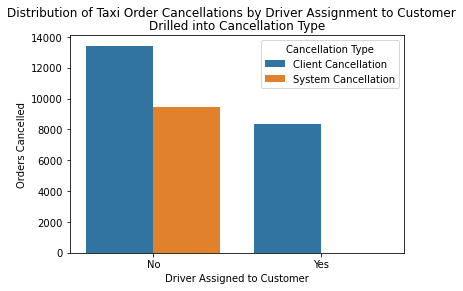

In [10]:
# building the barplot and passing the necessary variables through
sns.barplot(data = cancellations, x = 'is_driver_assigned', y = 'orders_cancelled', hue = 'order_status')

# passing the superior title, because there is a drill down to cancellation type, adding a subtitle 
plt.suptitle("Distribution of Taxi Order Cancellations by Driver Assignment to Customer")

# creating the subtitle
plt.title("Drilled into Cancellation Type")

# switching the legend title from order_status to Cancellation Type
plt.legend(title = "Cancellation Type")

# renaming the x axis Driver Assigned to Customer 
plt.xlabel("Driver Assigned to Customer")

# renaming the y axis Orders Cancelled
plt.ylabel("Orders Cancelled")
plt.show();

### Observations

+ 73% of Cancellations occur before a driver is assigned
+ After the driver is assigned, however, it is almost always the customer cancelling the order
+ There were 4 orders rejected by the system, which may be worth exploring how often this happens and the cost associated with it
+ It should be flagged to Product and Engineering to be on their radar, and if the cost is high, it may become a higher priority

### Some Questions...

+ The data above has been helpful in understand where the root of the cancellations begin
+ But a few questions comes to mind..

### Such As

+ When are most of these cancellations happening from an hour perspective?
+ What are the drivers behind so many customers cancelling their orders before a driver is assigned? - It would be helpful to know the average time to assign a driver for baseline
+ Could the Customer wait time for a driver being assigned to their order be a leading cause of cancellations?
+ How long are Customers approximately waiting to cancel their order prior to a driver being assigned?

## To answer that 

+ Build a table called cancellations by hour to under the distribution of cancellations by hour
+ Build a separate table called is_driver_assigned_hour
+ Have the total count of orders, as well as the average cancellation time in seconds geouped by hour and driver assigned

### Next Steps

+ Create a new column containing the hour to manipulate data
+ We do this by usind the dt.hour function with the datetime library
+ Create a table by hour and the number of cancellation to get a better illustration of the distribution

In [11]:
# creating a new column with the hour from the order time
df['hour'] = pd.to_datetime(df['order_time']).dt.hour

In [12]:
# taking a random sample from the dataset and looking at ten examples
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,hour
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946,Yes,Client Cancellation,21
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519,No,Client Cancellation,10
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740,No,Client Cancellation,9
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394,No,Client Cancellation,2
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163,No,Client Cancellation,21
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313,No,System Cancellation,3
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742,No,Client Cancellation,14
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957,No,System Cancellation,20
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801,No,Client Cancellation,18
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628,Yes,Client Cancellation,7


In [33]:
# creating a new table that has order cancellations by hour 
cancellations_by_hour = df.groupby('hour')['order_gk'].count().reset_index().rename({"order_gk" : "cancellation count"}, axis = 1)

# creating a new column to measure percentage of cancellations by hour from the total
cancellations_by_hour['perc_of_cancellations'] = round(cancellations_by_hour['cancellation count'] / cancellations_by_hour['cancellation count'].sum() * 100 , 2)

# looking at the entire dataframe to ensure the data looks good
cancellations_by_hour

,hour,cancellation count,perc_of_cancellations
0,0,1993,6.37
1,1,1305,4.17
2,2,1475,4.72
3,3,1418,4.53
4,4,227,0.73
5,5,111,0.35
6,6,392,1.25
7,7,1566,5.01
8,8,3865,12.36
9,9,1258,4.02


### Creating a line graph visual of the order cancellations by hour

+ Looking at the data above, the line graph will have a big speak in the middle of morning hours given the fact 8 am has the biggest number of cancellations
+ Cancellations begin to rise in the afternoon so there will be peaks towards 3 pm or 15
+ There is a slight drop for about an hour, and towards nighttime and early morning hours the volume of cancellations rises

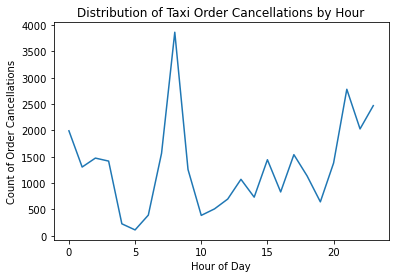

In [14]:
# creating the line graph and passing variables
sns.lineplot(data = cancellations_by_hour, x = 'hour', y = 'cancellation count')

# adding a title to called Distribution of Cancellations by Hour
plt.title('Distribution of Taxi Order Cancellations by Hour')

# renaming x axis to Hour of Day for clarity
plt.xlabel('Hour of Day')

# renaming the y axis to Count of Order Cancellations
plt.ylabel('Count of Order Cancellations')

plt.show();

### Observations from the visual above

+ Looking at the line graph above, it tells the story of cancellations in an easier to digest format
+ Higher peaks in the early hours in the morning, followed by a big drop and then followed by the big 8 AM cancellation peak
+ Cancellations stay somehat consistent for the afternoon and around 8 PM the peaks begin to get bigger again

### Next Steps 

+ Create a table getting the cancellation count and average cancellation time grouped by the hour and is_driver_assigned
+ We will need to calculate the average cancellation unassigned and assigned orders to understand if wait times could be a main contributor to the cancellations

In [15]:
# creating a table for distribution of cancellations grouped by the hour, driver assignment 
hour_type_cancellations = df.groupby(['hour', 'is_driver_assigned', 'order_status'])['order_gk'].count().reset_index().rename({"order_gk" : "cancellation count"}, axis = 1)

# displaying a sample of the data to ensure it worked
hour_type_cancellations.sample(n = 10, random_state = 42)

,hour,is_driver_assigned,order_status,cancellation count
4,1,No,Client Cancellation,633
63,20,Yes,Client Cancellation,346
18,5,Yes,Client Cancellation,47
0,0,No,Client Cancellation,957
28,9,No,Client Cancellation,470
72,23,Yes,Client Cancellation,444
10,3,No,Client Cancellation,565
34,11,No,Client Cancellation,155
12,3,Yes,Client Cancellation,195
55,18,No,Client Cancellation,447


### Distribution of Hours Complete, moving on to

+ Create is_driver_assigned_hour table
+ Table is group by hour, and is driver assigned, counting the number of cancelled orders and also measuring cancellations in seconds

### Goal

+ What are the drivers behind so many customers cancelling their orders before a driver is assigned?
+ Could the Customer wait time for a driver being assigned to their order be a leading cause?
+ How long are Customers approximately waiting to cancel their order prior to a driver being assigned?

In [42]:
# creating a new table getting the cancellation count and average cancellation time grouped by the hour and is_driver_assigned
is_driver_assigned_hour = df.groupby(['hour', 'is_driver_assigned']).agg({"order_gk" : "count", "cancellations_time_in_seconds" : "mean"}).reset_index().rename({"order_gk" : "cancellation count"}, axis = 1)

# rounding the cancellations time in seconds to nearest 2 decimal points
is_driver_assigned_hour['cancellations_time_in_seconds'] = round(is_driver_assigned_hour['cancellations_time_in_seconds'], 2)

# getting the average cancellation time by assigned orders (meaning a driver was assigned)
assigned_avg = round(is_driver_assigned_hour[is_driver_assigned_hour['is_driver_assigned'] == 'Yes']['cancellations_time_in_seconds'].mean(),2)

# getting the average cancellation time by assigned orders (meaning a driver was assigned)
unassigned_avg = round(is_driver_assigned_hour[is_driver_assigned_hour['is_driver_assigned'] == 'No']['cancellations_time_in_seconds'].mean(),2)
    
# looking at the entire dataset to
is_driver_assigned_hour

,hour,is_driver_assigned,cancellation count,cancellations_time_in_seconds
0,0,No,1663,115.13
1,0,Yes,330,276.08
2,1,No,1007,100.59
3,1,Yes,298,296.31
4,2,No,1235,121.31
5,2,Yes,240,301.47
6,3,No,1223,129.18
7,3,Yes,195,368.68
8,4,No,135,100.73
9,4,Yes,92,245.25


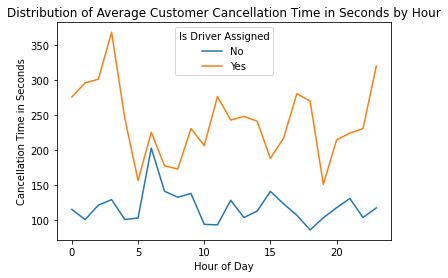

In [17]:
sns.lineplot(data = is_driver_assigned_hour, x = 'hour', y = 'cancellations_time_in_seconds', hue = 'is_driver_assigned')
plt.title('Distribution of Average Customer Cancellation Time in Seconds by Hour')
plt.legend(title = 'Is Driver Assigned', loc = 'best')
plt.xlabel('Hour of Day')
plt.ylabel('Cancellation Time in Seconds')
plt.show();

### Observations

+ Most of the unassigned cancellations are less than or close to 2 minutes, aside from 6 in the Morning
+ This is interesting, considering 8 AM is the hour with the most cancellations